权重衰减是减轻过拟合的一种常用方法，等价于L2范数正则化  
具体方法是引入L2范数惩罚项，主要是惩罚绝对值较大的参数从而限制模型  
以下是一个权重衰减从零实现缓解过拟合的实践

In [2]:
#这里用了一个高维线性回归来模拟过拟合的情况
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
import d2lzh_pytorch as d2l
n_train,n_test,num_inputs = 20,100,200
#训练数据的数量和测试数据的数量
true_w,true_b = torch.ones(num_inputs,1)*0.01,0.05
features = torch.randn((n_train+n_test,num_inputs))
labels = torch.matmul(features,true_w)+true_b
labels = torch.tensor(np.random.normal(0,0.01,size = labels.size()),dtype = torch.float)
train_features,test_features = features[:n_train,:],features[n_train:,:]
train_labels,test_labels = labels[:n_train],labels[n_train:]


In [3]:
#初始化模型参数
def init_params():
    w = torch.randn((num_inputs,1),requires_grad = True)
    b = torch.zeros(1,requires_grad= True)
    return [w,b]

In [4]:
#定义L2范数惩罚项
def l2_penalty(w):
    return (w**2).sum()/2

In [5]:
#定义训练和测试
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)
batch_size,num_epochs,lr = 1,100,0.003
net = d2l.linreg
loss = d2l.squared_loss
dataset = torch.utils.data.TensorDataset(train_features,train_labels)
train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
def fit_and_plot(lambd):
    w,b = init_params()
    train_ls,test_ls=[],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X,w,b),y)+lambd*l2_penalty(w)
            l = l.sum()
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w,b],lr,batch_size)
        train_ls.append(loss(net(train_features,w,b),train_labels).mean())
        test_ls.append(loss(net(test_features,w,b),test_labels).mean())
    #这里和书中的源代码有区别，加了下面两行代码，把pytoch转换为了numpy数组，供matplotlib绘图使用
    train_ls_np = [loss.detach().numpy() for loss in train_ls]
    test_ls_np = [loss.detach().numpy() for loss in test_ls]
    semilogy(range(1,num_epochs+1),train_ls_np,'epochs','loss',
                 range(1,num_epochs+1),test_ls_np,['train','test'])
    print('L2 norm of w:',w.norm().item())
        

L2 norm of w: 13.688223838806152


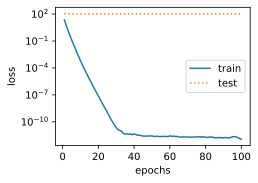

In [6]:
#如果lambd为0，就是没有使用权重衰减
fit_and_plot(0)

可以看到上面的提，train的loss可以降到很低，但是test的loss一直不下降，是一种过拟合现象  
如果此时引入l2范数惩罚项，进行梯度衰减（也就是lambd不为0）

L2 norm of w: 0.01628626137971878


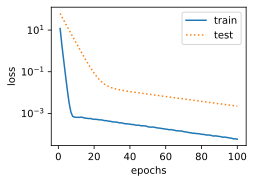

In [7]:
fit_and_plot(3)

testloss就可以下降了，可以缓解过拟合的现象

下面使用pytorch进行参数衰减的简洁实现

In [19]:
def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs,1)
    nn.init.normal_(net.weight,mean=0,std=1)
    nn.init.normal_(net.bias,mean=0,std=1)
    optimizer_w = torch.optim.SGD(params = [net.weight],lr=lr,weight_decay = wd)
    #这里的weight——decay参数就是来指定权重衰减超参数的，默认情况下pytorch会对权重和偏差同时衰减，可以分别对权重和偏差构造优化器实例，从而之ui权重进行衰减
    optimizer_b = torch.optim.SGD(params = [net.bias],lr=lr)
    train_ls,test_ls=[],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            #调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()

        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features),test_labels).mean().item())
    semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',
    range(1,num_epochs+1),test_ls,['train','test'])
    print('L2 for norm of w:',net.weight.data.norm().item())

L2 for norm of w: 12.571537971496582


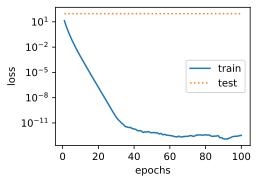

In [20]:
fit_and_plot_pytorch(0)

L2 for norm of w: 0.03272911533713341


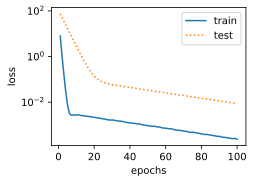

In [21]:
fit_and_plot_pytorch(3)